In [1]:
from glob import glob
from itertools import product
from noise import add_noise, decompress_pickle
import mat73
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from training_sktime import normalizing, format_dataframe
from sklearn.metrics import accuracy_score
import pickle
MODEL_PATH = './models/new_dataset/'
INPUT_DATA_PATH = '../input-data/'

In [2]:
signal = 'i'
# cycle = 'cycle_32'

for cycle in ['cycle_32', 'cycle_64', 'cycle_128']:
    X_train_flavio = decompress_pickle(INPUT_DATA_PATH + f'folds/{signal}/{cycle}/X_train')
    X_val_flavio = decompress_pickle(INPUT_DATA_PATH + f'folds/{signal}/{cycle}/X_val')
    y_val_flavio = decompress_pickle(INPUT_DATA_PATH + f'folds/{signal}/{cycle}/y_val')

    X_train_robson = decompress_pickle(INPUT_DATA_PATH + f'folds-robson/{signal}/{cycle}/X_train')
    X_val_robson = decompress_pickle(INPUT_DATA_PATH + f'folds-robson/{signal}/{cycle}/X_val')
    y_val_robson = decompress_pickle(INPUT_DATA_PATH + f'folds-robson/{signal}/{cycle}/y_val')

    X_train = pd.concat([X_train_flavio, X_train_robson]).reset_index(drop=True)
    X_val = pd.concat([X_val_flavio, X_val_robson]).reset_index(drop=True)
    y_val = np.concatenate([y_val_flavio, y_val_robson])
            
    max_cycle_1 = pickle.load(open(MODEL_PATH + f'minirocket_{cycle}_max_values.pkl', 'rb'))
    minirocket = pickle.load(open(MODEL_PATH + f'minirocket_{cycle}.pkl', 'rb'))
    model = pickle.load(open(MODEL_PATH + f'minirocket_classifier_{cycle}.pkl', 'rb'))
    X_val_norm = normalizing(X_val, max_cycle_1)
    X_trans = minirocket.transform(X_val_norm)
    y_pred = model.predict(X_trans)
    
    print(cycle)
    print(accuracy_score(y_val, y_pred) * 100)
    indexes = np.where((y_val == y_pred) == False)[0]
    first_dataset = (indexes <= 187).sum()
    second_dataset = len(indexes) - first_dataset
    print(f'Erros para o primeiro dataset: {first_dataset}')
    print(f'Erros para o segundo dataset: {second_dataset}')
    print('\n')
    print('*'*10)

cycle_32
66.75531914893617
Erros para o primeiro dataset: 2
Erros para o segundo dataset: 123


**********
cycle_64
57.97872340425532
Erros para o primeiro dataset: 4
Erros para o segundo dataset: 154


**********
cycle_128
53.72340425531915
Erros para o primeiro dataset: 5
Erros para o segundo dataset: 169


**********


In [5]:
(np.where((y_val == y_pred) == False)[0] <= 187).sum()

5

66.75531914893617

In [4]:
display(len(y_val_flavio))
display(len(y_val_robson))
display(len(y_val))

188

188

376

In [6]:
np.where((y_val == y_pred) == False)[0]

array([ 17, 140, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199,
       200, 202, 203, 204, 205, 206, 207, 208, 210, 213, 214, 216, 217,
       220, 221, 222, 223, 224, 226, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 239, 240, 243, 244, 245, 246, 247, 248, 249, 252,
       253, 256, 259, 260, 261, 265, 266, 268, 269, 270, 273, 275, 276,
       277, 279, 280, 281, 282, 283, 284, 285, 286, 288, 291, 292, 293,
       296, 297, 298, 300, 302, 303, 305, 307, 308, 310, 311, 312, 313,
       315, 316, 317, 318, 320, 326, 328, 329, 330, 331, 334, 335, 336,
       340, 342, 343, 349, 350, 351, 352, 353, 354, 356, 357, 359, 360,
       362, 363, 364, 366, 367, 370, 371, 374])

In [4]:
pd.DataFrame([y_val, y_pred], columns=['True', 'Predicted'])

ValueError: 2 columns passed, passed data had 376 columns

In [6]:
model

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [14]:
X_trans = minirocket.transform(X_val_norm)

y_pred = model.predict(X_trans)

In [18]:

accuracy_score(y_val, y_pred)

9.574468085106384

# Testando antes

In [2]:
path = '../input-data/dados_robson/Sinais_Robson/'
files = glob(path + '*.mat')

In [3]:
disparo = [file for file in files if 'disparo' in file ][0]

In [4]:
for i, file in enumerate(files):
    if 'disparo' in file:
        disparo = file
        del files[i]

In [5]:
distance = range(3)
resistance = range(3)
compensation = range(4)
angle = range(19)

indexes = list(product(distance, resistance, compensation, angle))

In [6]:
i_v = 'I'
signal_dict = {}
for file in files:
    data = mat73.loadmat(file)
    fault_type = file.split('_')[-1].split('.')[0]
    signal = data[f'{i_v}_{fault_type}']
    signals = []
    for i in indexes:
        # Adiciona ruído
        phase = signal[:,:, i[0], i[1], i[2], i[3]]
        noiseA = add_noise(phase[:, 0], 60)
        noiseB = add_noise(phase[:, 1], 60)
        noiseC = add_noise(phase[:, 2], 60)
        three_phase_signal = np.vstack((noiseA, noiseB, noiseC)).T
        signals.append({i[3]: three_phase_signal})
    signal_dict[fault_type] = signals

In [7]:
angle_dict = {}
for i, item in enumerate(sio.loadmat(disparo)['Flt_trip']):
    value = np.where(item[:-1] != item[1:])[0][0]
    angle_dict[i] = value

In [8]:
detected_signal_dict = {}
for key in signal_dict.keys():
    detected_signals = []
    for item in signal_dict[key]:
        a = list(item.keys())[0]
        index = angle_dict[a]
        # Pega 1/4 pré falta e 1 ciclo pós falta
        detected_signal = item[a][index-64:index+256]
        detected_signals.append(detected_signal)
    detected_signal_dict[key] = detected_signals

In [9]:
detected_signal_dict.keys()

dict_keys(['BCG', 'BC', 'ABG', 'CA', 'CG', 'AG', 'CAG', 'BG', 'AB', 'ABC'])

In [10]:
detected_signal_dict['ABG'][0].shape

(320, 3)

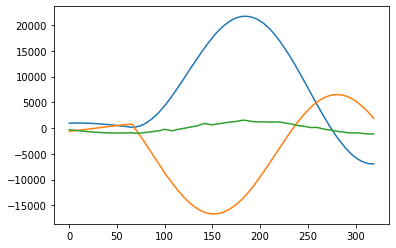

In [11]:
plt.plot(detected_signal_dict['ABG'][0]);

In [12]:
MODEL_PATH = './models/'

In [13]:
import pickle
a = pickle.load(open(MODEL_PATH + 'minirocket_cycle_1_max_values.pkl', 'rb'))

In [14]:
signal_1cycle = []
for key in detected_signal_dict.keys():
    s = detected_signal_dict[key]
    fault_type = key
    for i, item in enumerate(s):
        Xa = item[:, 0]
        Xb = item[:, 1]
        Xc = item[:, 2]
        Xz = Xa + Xb + Xc
        X = normalizing({'A': Xa, 'B': Xb, 'C': Xc, 'Z': Xz}, a)
        stacked_signal = np.hstack([X['A'], X['B'], X['C'], X['Z']])
        signal_1cycle.append({'signal': stacked_signal, 'fault_type': fault_type})

In [15]:
len(signal_1cycle)

6840

In [16]:
signal_1cycle[0].keys()

dict_keys(['signal', 'fault_type'])

BCG


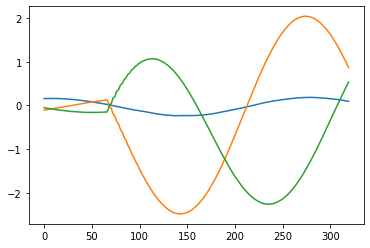

In [17]:
print(signal_1cycle[0]['fault_type'])
plt.plot(signal_1cycle[0]['signal'][:320]);
plt.plot(signal_1cycle[0]['signal'][320:640]);
plt.plot(signal_1cycle[0]['signal'][640:960]);
# plt.plot(signal_1cycle[0]['signal'][960:1280]);

In [18]:
data_list = []
target_list = []
for d in signal_1cycle:
    data_list.append(format_dataframe(d['signal']))
    target_list.append(d['fault_type'])
X = pd.concat(data_list).reset_index(drop=True)
y = np.array(target_list)

In [19]:
y

array(['BCG', 'BCG', 'BCG', ..., 'ABC', 'ABC', 'ABC'], dtype='<U3')

In [20]:
X

,A,B,C,Z
0,0 0.156751 1 0.157302 2 0.15812...,0 -0.107558 1 -0.100911 2 -0.09886...,0 -0.050333 1 -0.054994 2 -0.05827...,0 -0.002195 1 0.002790 2 0.00201...
1,0 0.159641 1 0.159349 2 0.15946...,0 -0.079632 1 -0.076608 2 -0.07013...,0 -0.080219 1 -0.083299 2 -0.08733...,0 -0.000290 1 -0.000963 2 0.00405...
2,0 0.157078 1 0.156431 2 0.15520...,0 -0.053764 1 -0.050868 2 -0.04573...,0 -0.103887 1 -0.105501 2 -0.10832...,0 -0.000932 1 0.000317 2 0.00243...
3,0 0.150021 1 0.148668 2 0.14688...,0 -0.025884 1 -0.024340 2 -0.02121...,0 -0.121566 1 -0.124431 2 -0.12684...,0 0.005283 1 0.000052 2 -0.00205...
4,0 0.138476 1 0.136509 2 0.13433...,0 0.001216 1 0.003683 2 0.00822...,0 -0.138651 1 -0.140146 2 -0.14158...,0 0.002341 1 0.000398 2 0.00221...
...,...,...,...,...
6835,0 -0.102127 1 -0.105179 2 -0.10809...,0 0.157417 1 0.156708 2 0.15593...,0 -0.055146 1 -0.051768 2 -0.04802...,0 0.000507 1 -0.000253 2 -0.00016...
6836,0 -0.121561 1 -0.124110 2 -0.12657...,0 0.150601 1 0.149002 2 0.14758...,0 -0.028940 1 -0.025005 2 -0.02110...,0 0.000359 1 -0.000069 2 -0.00005...
6837,0 -0.137615 1 -0.139387 2 -0.14131...,0 0.139023 1 0.137136 2 0.13506...,0 -0.001615 1 0.002376 2 0.00634...,0 -0.000310 1 0.000331 2 0.00026...
6838,0 -0.149435 1 -0.150673 2 -0.15213...,0 0.123472 1 0.120966 2 0.11837...,0 0.025879 1 0.029667 2 0.03353...,0 -0.000139 1 -0.000063 2 -0.00042...


In [21]:
X['y'] = y

In [22]:
X = X.sample(frac = 1).reset_index(drop=True)
y = X['y'].values
X = X.drop(columns='y')

In [23]:
minirocket = pickle.load(open(MODEL_PATH + 'minirocket_cycle_1.pkl', 'rb'))

In [24]:
minirocket

MiniRocketMultivariate(random_state=42)

In [28]:
X_trans = minirocket.transform(X)

In [29]:
model = pickle.load(open(MODEL_PATH + 'minirocket_classifier_cycle_1.pkl', 'rb'))
y_pred = model.predict(X_trans)

In [30]:
y_pred

array(['AB', 'AB', 'AT', ..., 'BCT', 'CAT', 'BCT'], dtype='<U3')

In [34]:
y = np.array(list(map(lambda x: x.replace('G', 'T'), y)))

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred, normalize=False)

3262